In [7]:
#mask tidal forcing
import xarray as xr
import os
import sys
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import numpy as np

src_path = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_path)
# import my functions
from features.log_progress import log_progress
from features.grid_ttide import NDinterp

pott_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_data','waom10_tds_2007_hack.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_large.nc')
grid = xr.open_dataset(grid_path)

In [53]:
%%writefile ../../src/features/mask_radius.py
import xarray as xr
import numpy as np
from features.log_progress import log_progress

find = lambda searchList, elem: [[i for i, x in enumerate(searchList) if x == e] for e in elem]

def rosby_mask(mask_da,mask_rho,r=10):
    
    neibours_add = []
    for n_xi in np.arange(0,r+1,2):
        for n_eta in np.arange(0,r+1,2):
            if (n_xi**2 + n_eta**2) <= r**2:
                neibours_add.append([n_xi,n_eta])
                if n_xi > 0:
                    neibours_add.append([-n_xi,n_eta])
                if n_eta > 0:
                    neibours_add.append([n_xi,-n_eta])
                if n_xi > 0 and n_eta > 0:
                    neibours_add.append([-n_xi,-n_eta])
                  
    mask_rho_stacked = mask_rho.stack(xieta=('xi_rho','eta_rho')).values
    xieta = mask_rho.stack(xieta=('xi_rho','eta_rho')).xieta.values
    
    xi_len = mask_rho.xi_rho.size
    eta_len = mask_rho.eta_rho.size
    for xi in log_progress(np.arange(xi_len),name='xi'):
        for eta in np.arange(eta_len):
            if mask_da[eta,xi] == 1:          
                neibours = np.add(neibours_add,(xi,eta))
                new=[]
                for ind,neib in enumerate(neibours):
                    if (0 <= neib[0] <= xi_len-1) and (0 <= neib[1] <= eta_len-1):
                        new.append(tuple(neib))
                neibours = new
                    
                stack_ind = np.squeeze(find(xieta,neibours))
                if (mask_rho_stacked[stack_ind]==0).any():
                    mask_da[eta,xi] = 0
                
    return mask_da

Overwriting ../../src/features/mask_radius.py


In [40]:
from scipy import ndimage
a = grid.mask_rho.values
a[grid.zice.values < 0.0] = 0

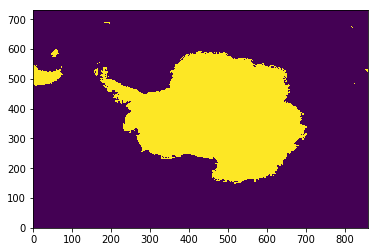

In [41]:
plt.close()
plt.pcolormesh(np.logical_not(a))
plt.show()

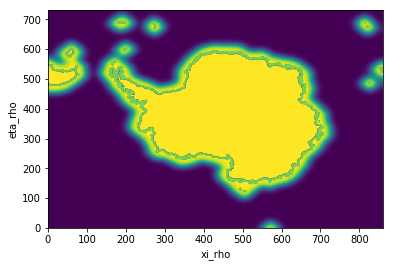

In [44]:
b = ndimage.binary_dilation(np.logical_not(a),iterations=25).astype(a.dtype)
from scipy.ndimage.filters import gaussian_filter, uniform_filter
c = gaussian_filter(b,10)
plt.close()
plt.pcolormesh(c,alpha=0.5)
grid.mask_rho.plot.contour()
plt.show()

In [45]:
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
pott_ds

<xarray.Dataset>
Dimensions:             (eta_rho: 730, string: 4, tide_period: 13, xi_rho: 860)
Coordinates:
  * tide_period         (tide_period) timedelta64[ns] 0 days 12:25:14.163600 ...
Dimensions without coordinates: eta_rho, string, xi_rho
Data variables:
    lat_rho             (eta_rho, xi_rho) float64 ...
    lon_rho             (eta_rho, xi_rho) float64 ...
    mask_rho            (eta_rho, xi_rho) float64 ...
    tide_Cphase         (tide_period, eta_rho, xi_rho) float64 ...
    tide_Cangle         (tide_period, eta_rho, xi_rho) float64 ...
    tide_Cmin           (tide_period, eta_rho, xi_rho) float64 ...
    tide_Cmax           (tide_period, eta_rho, xi_rho) float64 ...
    tidal_constituents  (string, tide_period) |S1 ...
    tide_Pamp           (tide_period, eta_rho, xi_rho) float64 ...
    tide_Pphase         (tide_period, eta_rho, xi_rho) float64 ...
Attributes:
    Type:       ROMS Tidal Forcing File
    Title:      Forcing for WAOM10_large  domain
    grid_file:  /h

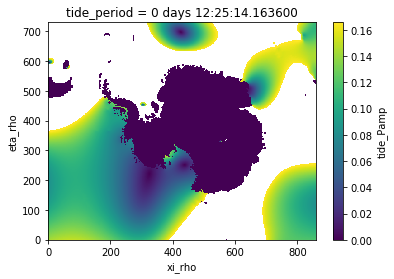

In [72]:
const = pott_ds.tide_Pamp[0].copy()
plt.close()
const.where(const <= (const.mean())).plot()
plt.show()

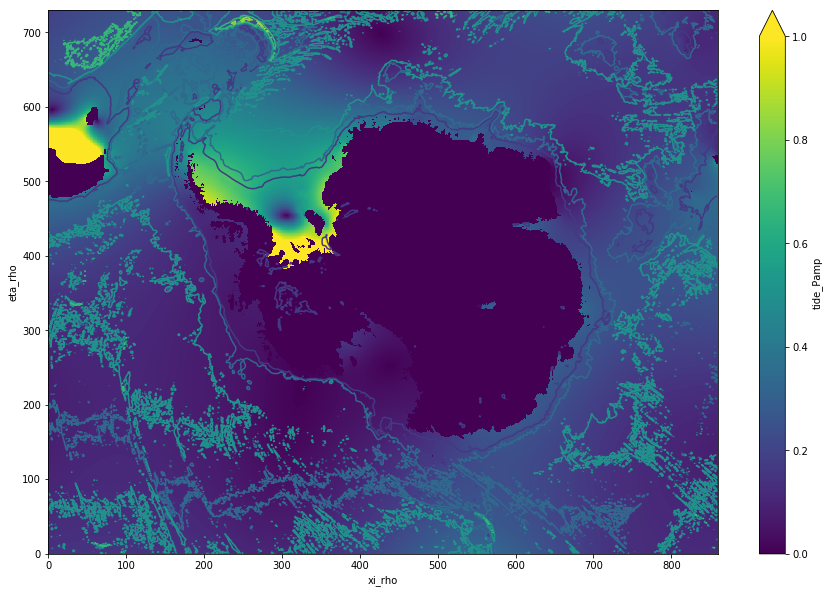

In [57]:
plt.close()
pott_ds.tide_Pamp[0].plot(vmax=1,size=10)
plt.show()

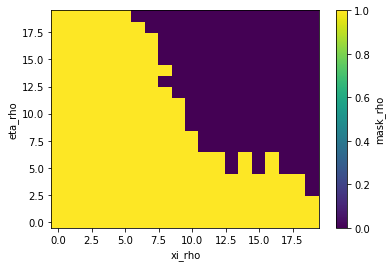

In [45]:
plt.close()
ma2.plot()
plt.show()

In [52]:
%%time
for round in np.arange(2):
    print(round)
    ma = rosby_mask(ma,ma,r=5)

0


VBox(children=(HTML(value=''), IntProgress(value=0, max=60)))

KeyboardInterrupt: 

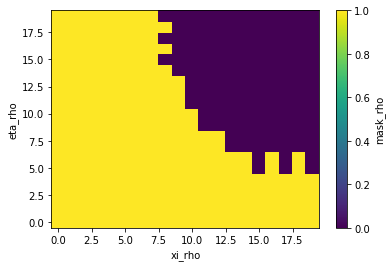

In [48]:
plt.close()
ma.plot()
plt.show()

In [23]:
#%%writefile ../../src/features/mask_radius.py

import xarray as xr
import numpy as np
from features.log_progress import log_progress

def rosby_mask(mask_da,mask_rho,r=10):

    neibours_add = []
    for n_xi in np.arange(0,r+1,2):
        for n_eta in np.arange(0,r+1,2):
            if (n_xi**2 + n_eta**2) <= r**2:
                neibours_add.append([n_xi,n_eta])
                if n_xi > 0:
                    neibours_add.append([-n_xi,n_eta])
                if n_eta > 0:
                    neibours_add.append([n_xi,-n_eta])
                if n_xi > 0 and n_eta > 0:
                    neibours_add.append([-n_xi,-n_eta])
                
    mask_rho_stacked = mask_rho.stack(xieta=('xi_rho','eta_rho'))
    
    for xi in log_progress(mask_da.xi_rho.values,name='xi'):
        for eta in mask_da.eta_rho.values:
            
            if mask_da[eta,xi] == 1:          
                neibours = np.add(neibours_add,(xi,eta))
                new=[]
                for ind,neib in enumerate(neibours):
                    if (mask_da.xi_rho[0].values <= neib[0] <= mask_da.xi_rho[-1]) and (mask_da.eta_rho[0].values <= neib[1] <= mask_da.eta_rho[-1]):
                        new.append(tuple(neib))
                neibours = new

                if (mask_rho_stacked.sel(xieta=neibours)==0).any().values == True:
                    mask_da[eta,xi] = 0
                
    return mask_da

VBox(children=(HTML(value=''), IntProgress(value=0, max=10)))

In [29]:
neibours_add = []
for n_xi in np.arange(0,r+1,2):
    for n_eta in np.arange(0,r+1,2):
        if (n_xi**2 + n_eta**2) <= r**2:
            neibours_add.append([n_xi,n_eta])
            if n_xi > 0:
                neibours_add.append([-n_xi,n_eta])
            if n_eta > 0:
                neibours_add.append([n_xi,-n_eta])
            if n_xi > 0 and n_eta > 0:
                neibours_add.append([-n_xi,-n_eta])
neibours_add = np.array(neibours_add)
neibours_add

array([[ 0,  0],
       [ 0,  2],
       [ 0, -2],
       [ 0,  4],
       [ 0, -4],
       [ 2,  0],
       [-2,  0],
       [ 2,  2],
       [-2,  2],
       [ 2, -2],
       [-2, -2],
       [ 2,  4],
       [-2,  4],
       [ 2, -4],
       [-2, -4],
       [ 4,  0],
       [-4,  0],
       [ 4,  2],
       [-4,  2],
       [ 4, -2],
       [-4, -2]])

In [43]:
mask_rho_stacked = grid.mask_rho[260:270,260:280].stack(xieta=('xi_rho','eta_rho')).values
xieta = grid.mask_rho[260:270,260:280].stack(xieta=('xi_rho','eta_rho')).xieta.values
xieta

array([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7),
       (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5),
       (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3),
       (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1),
       (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9),
       (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7),
       (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5),
       (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3),
       (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1),
       (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9),
       (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7),
       (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5),
       (9, 6), (9, 7), (9, 8), (9, 9), (10, 0), (10, 1), (10, 2), (10, 3),
       (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (11, 0),
   

In [38]:
mask_da = grid.mask_rho[260:270,260:280].values
mask_da.shape

(10, 20)

In [40]:
xi_len = np.size(mask_da,1)
eta_len = np.size(mask_da,0)
for xi in log_progress(np.arange(xi_len),name='xi'):
    for eta in np.arange(eta_len):
        if mask_da[eta,xi] == 1:          
                neibours = np.add(neibours_add,(xi,eta))
                new=[]
                for ind,neib in enumerate(neibours):
                    if (0 <= neib[0] <= xi_len) and (0 <= neib[1] <= eta_len):
                        new.append(tuple(neib))
                neibours = new 
neibours

VBox(children=(HTML(value=''), IntProgress(value=0, max=20)))

[(19, 9), (19, 7), (19, 5), (17, 9), (17, 7), (17, 5), (15, 9), (15, 7)]

In [59]:
type(neibours[0])

tuple

In [28]:
if (mask_rho_stacked.sel(xieta=neibours)==0).any().values == True:
                    mask_da[eta,xi] = 0

array([[9, 2],
       [9, 3],
       [9, 1],
       [9, 4],
       [9, 0],
       [9, 5],
       [9, 6],
       [9, 7],
       [8, 2],
       [8, 3],
       [8, 1],
       [8, 4],
       [8, 0],
       [8, 5],
       [8, 6],
       [7, 2],
       [7, 3],
       [7, 1],
       [7, 4],
       [7, 0],
       [7, 5],
       [7, 6],
       [6, 2],
       [6, 3],
       [6, 1],
       [6, 4],
       [6, 0],
       [6, 5],
       [6, 6],
       [5, 2],
       [5, 3],
       [5, 1],
       [5, 4],
       [5, 0],
       [5, 5],
       [4, 2]])

In [24]:
grid.mask_rho.values

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

### create list of additives to get neibours

In [65]:
r=3
neibours_add = []
for n_xi in np.arange(0,r+1):
    for n_eta in np.arange(0,r+1):
        if (n_xi**2 + n_eta**2) <= r**2:
            neibours_add.append([n_xi,n_eta])
            if n_xi > 0:
                neibours_add.append([-n_xi,n_eta])
            if n_eta > 0:
                neibours_add.append([n_xi,-n_eta])
            if n_xi > 0 and n_eta > 0:
                neibours_add.append([-n_xi,-n_eta])
            
neibours_add        

[(0, 0),
 (0, 1),
 [0, -1],
 (0, 2),
 [0, -2],
 (0, 3),
 [0, -3],
 (1, 0),
 [-1, 0],
 (1, 1),
 [-1, 1],
 [1, -1],
 [-1, -1],
 (1, 2),
 [-1, 2],
 [1, -2],
 [-1, -2],
 (2, 0),
 [-2, 0],
 (2, 1),
 [-2, 1],
 [2, -1],
 [-2, -1],
 (2, 2),
 [-2, 2],
 [2, -2],
 [-2, -2],
 (3, 0),
 [-3, 0]]

### stack mask_rho to single coordinate

In [120]:
mask_rho_stacked = grid.mask_rho.stack(xieta=('xi_rho','eta_rho'))

In [121]:
mask_rho_stacked.xieta

<xarray.DataArray 'xieta' (xieta: 627800)>
array([(0, 0), (0, 1), (0, 2), ..., (859, 727), (859, 728), (859, 729)], dtype=object)
Coordinates:
  * xieta    (xieta) MultiIndex
  - xi_rho   (xieta) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - eta_rho  (xieta) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [55]:
mask_rho_stacked.sel(xieta=[(0,0),(200,200)])

<xarray.DataArray 'mask_rho' (xieta: 2)>
array([ 1.,  1.])
Coordinates:
  * xieta    (xieta) MultiIndex
  - xi_rho   (xieta) int64 0 200
  - eta_rho  (xieta) int64 0 200
Attributes:
    long_name:      mask on RHO-points
    flag_values:    [ 0.  1.]
    flag_meanings:  land water

### for single cell, create neibours list and loop up if any mask_rho_stack of this list is 0

In [123]:

xi = grid.mask_rho.xi_rho[-1]
eta = grid.mask_rho.eta_rho[-1]
neibours = np.add(neibours_add,(xi,eta))
new=[]
for ind,neib in enumerate(neibours):
    if (0 <= neib[0] <= mask_da.xi_rho[-1]) and (0 <= neib[1] <= mask_da.eta_rho[-1]):
        new.append(tuple(neib))
neibours = new
neibours

[(859, 729),
 (859, 728),
 (859, 727),
 (859, 726),
 (858, 729),
 (858, 728),
 (858, 727),
 (857, 729),
 (857, 728),
 (857, 727),
 (856, 729)]

In [124]:
(mask_rho_stacked.sel(xieta=neibours)==0).any().values == True

False

In [63]:
x,y = np.mgrid[0:grid.xi_rho.size,0:grid.eta_rho.size]
points = np.column_stack((x.flatten(),y.flatten()))
tree = spatial.KDTree(points)

In [108]:
xi,eta = 859,729

In [99]:
mask_da = grid.mask_rho
neib = []
for n_xi in np.arange(0,r+1):
    for n_eta in np.arange(0,r+1):
        if (n_xi**2 + n_eta**2) > r**2:
            break
        else:
            if (xi-n_xi >= 0) and (eta-n_eta >= 0):
                neib.append([xi-n_xi,eta-n_eta])
            elif (xi+n_xi <= grid.xi_rho[-1]) and (eta+n_eta <= grid.eta_rho[-1]):
                neib.append([xi+n_xi,eta+n_eta])
neib

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [1, 0],
 [1, 1],
 [1, 2],
 [2, 0],
 [2, 1],
 [2, 2],
 [3, 0]]

In [ ]:
grid

In [135]:
%%writefile ../src/features/mask_radius.py
import xarray as xr
from .log_progress import log_progress
import numpy as np

def get_neibours(xi,eta,r,grid):
    neibours = []
    r=int(r/2)
    for n_xi in np.arange(0,r+1):
        for n_eta in np.arange(0,r+1):
            if (n_xi**2 + n_eta**2) > r**2:
                break
            else:
                if (xi-n_xi >= 0) and (eta-n_eta >= 0):
                    neibours.append([xi-n_xi,eta-n_eta])
                elif (xi+n_xi <= grid.xi_rho[-1]) and (eta+n_eta <= grid.eta_rho[-1]):
                    neibours.append([xi+n_xi,eta+n_eta])
    return neibours

def mask_radius(mask_da,r):
    mask_new = mask_da.copy()
    for xi in log_progress(mask_da.xi_rho.values,name='xi'):
        for eta in mask_da.eta_rho.values:
            if mask_da.isel(eta_rho=eta,xi_rho=xi) != 0:
                neibours = get_neibours(xi,eta,r,mask_da)
                for neib in neibours:
                    if mask_da.isel(xi_rho=neib[0],eta_rho=neib[1]).values == 0:
                        mask_new[eta,xi]=0
                        break
    return mask_new

Overwriting ../src/features/mask_radius.py


In [132]:
tide_mask = mask_radius(grid.mask_rho,10)

VBox(children=(HTML(value=''), IntProgress(value=0, max=70)))

<IPython.core.display.Javascript object>


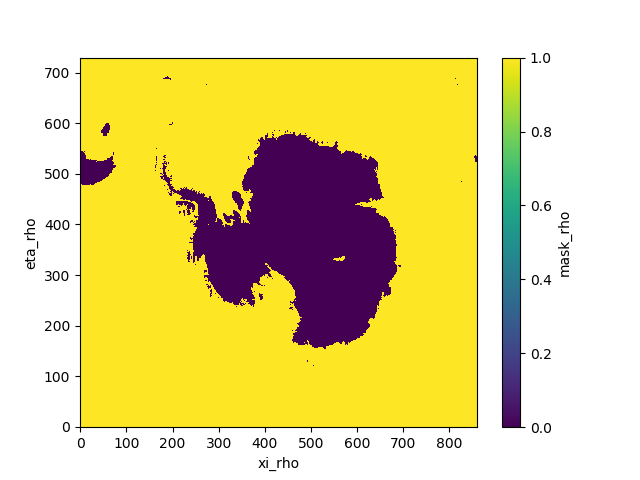

In [133]:
%matplotlib notebook
plt.close()
tide_mask.plot()
plt.show()

In [50]:
mask_tide[0,0]

TypeError: 'method' object is not subscriptable

0 0
0 1
0 2
1 0
1 1
2 0
